In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drug-interaction-dataset/drugbank_train.csv
/kaggle/input/drug-interaction-dataset/drugbank_test.csv


In [3]:
# ============================================================
# CELL 1: Install Dependencies
# ============================================================

!pip install -q torch-geometric
!pip install -q rdkit-pypi
!pip install -q tqdm

print("✓ Dependencies installed")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 72.9 MB/s eta 0:00:00:00:0100:01
✓ Dependencies installed


In [4]:
# ============================================================
# CELL 2: Import Libraries
# ============================================================

import pandas as pd
import torch
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from rdkit import Chem
from tqdm import tqdm
import numpy as np
import time
import gc
import os

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


In [5]:
# ============================================================
# CELL 3: Define Helper Functions
# ============================================================

def atom_feature_vector(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        atom.GetNumImplicitHs(),
        int(atom.GetIsAromatic()),
    ]

def bond_feature_vector(bond):
    bt = bond.GetBondType()
    return [
        bt == Chem.rdchem.BondType.SINGLE,
        bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE,
        bt == Chem.rdchem.BondType.AROMATIC,
    ]

def mol_to_graph_data_obj(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom_feature_vector(atom))

    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))
        edge_attr.append(bond_feature_vector(bond))
        edge_attr.append(bond_feature_vector(bond))

    data = Data(
        x=torch.tensor(atom_features, dtype=torch.float),
        edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(),
        edge_attr=torch.tensor(edge_attr, dtype=torch.float),
    )
    return data

print("✓ Helper functions defined")

✓ Helper functions defined


In [8]:
# ============================================================
# CELL 4: Load and Process Data
# ============================================================

# Find your dataset path (Kaggle automatically mounts datasets)
# Update this path to match your dataset name
dataset_path = '/kaggle/input/drug-interaction-dataset'

# List available files
print("Available files:")
for root, dirs, files in os.walk('/kaggle/input/'):
    for file in files:
        print(f"  {os.path.join(root, file)}")

# Load datasets - UPDATE THESE PATHS
train_file = dataset_path + '/drugbank_train.csv'
test_file = dataset_path + '/drugbank_test.csv'

print(f"\nLoading training data from: {train_file}")
train_df = pd.read_csv(train_file)
print(f"Train samples: {len(train_df):,}")

print(f"\nLoading test data from: {test_file}")
test_df = pd.read_csv(test_file)
print(f"Test samples: {len(test_df):,}")

# Rename columns if needed
if train_df.columns.tolist() == ['label', 'smile1', 'smile2']:
    train_df.columns = ['Label', 'Drug1_SMILES', 'Drug2_SMILES']
    test_df.columns = ['Label', 'Drug1_SMILES', 'Drug2_SMILES']

print(f"\nColumns: {train_df.columns.tolist()}")
print(f"Label distribution (train):\n{train_df['Label'].value_counts()}")



Available files:
  /kaggle/input/drug-interaction-dataset/drugbank_train.csv
  /kaggle/input/drug-interaction-dataset/drugbank_test.csv

Loading training data from: /kaggle/input/drug-interaction-dataset/drugbank_train.csv
Train samples: 354,436

Loading test data from: /kaggle/input/drug-interaction-dataset/drugbank_test.csv
Test samples: 88,610

Columns: ['Label', 'Drug1_SMILES', 'Drug2_SMILES']
Label distribution (train):
Label
0.0    177348
1.0    177088
Name: count, dtype: int64


In [9]:
# ============================================================
# CELL 5: Process Training Data
# ============================================================

print("\n" + "="*60)
print("PROCESSING TRAINING DATA")
print("="*60)

train_data1 = []
train_data2 = []
train_labels = []
invalid_train = 0

for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Train"):
    data1 = mol_to_graph_data_obj(row['Drug1_SMILES'])
    data2 = mol_to_graph_data_obj(row['Drug2_SMILES'])
    
    if data1 is None or data2 is None:
        invalid_train += 1
        continue
    
    train_data1.append(data1)
    train_data2.append(data2)
    train_labels.append(row['Label'])

train_labels = torch.tensor(train_labels, dtype=torch.float)

print(f"✓ Valid train pairs: {len(train_labels):,}")
print(f"✗ Invalid train pairs: {invalid_train:,}")

# Clear memory
del train_df
gc.collect()


PROCESSING TRAINING DATA


Train: 100%|██████████| 354436/354436 [09:12<00:00, 640.94it/s]


✓ Valid train pairs: 354,436
✗ Invalid train pairs: 0


0

In [10]:
# ============================================================
# CELL 6: Process Test Data
# ============================================================

print("\n" + "="*60)
print("PROCESSING TEST DATA")
print("="*60)

test_data1 = []
test_data2 = []
test_labels = []
invalid_test = 0

for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Test"):
    data1 = mol_to_graph_data_obj(row['Drug1_SMILES'])
    data2 = mol_to_graph_data_obj(row['Drug2_SMILES'])
    
    if data1 is None or data2 is None:
        invalid_test += 1
        continue
    
    test_data1.append(data1)
    test_data2.append(data2)
    test_labels.append(row['Label'])

test_labels = torch.tensor(test_labels, dtype=torch.float)

print(f"✓ Valid test pairs: {len(test_labels):,}")
print(f"✗ Invalid test pairs: {invalid_test:,}")

# Clear memory
del test_df
gc.collect()

print("\n✓ Data processing complete!")


PROCESSING TEST DATA


Test: 100%|██████████| 88610/88610 [02:17<00:00, 645.89it/s]


✓ Valid test pairs: 88,610
✗ Invalid test pairs: 0

✓ Data processing complete!


In [11]:
# ============================================================
# CELL 7: Create DataLoaders
# ============================================================

class MoleculeInteractionDataset(Dataset):
    def __init__(self, data_list1, data_list2, labels):
        self.data_list1 = data_list1
        self.data_list2 = data_list2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data_list1[idx], self.data_list2[idx], self.labels[idx]

def collate_fn(batch):
    data1_list, data2_list, label_list = zip(*batch)
    data1_batch = Batch.from_data_list(data1_list)
    data2_batch = Batch.from_data_list(data2_list)
    label_batch = torch.stack(label_list, dim=0).float().view(-1, 1)
    return data1_batch, data2_batch, label_batch

BATCH_SIZE = 128  # Kaggle GPU can handle this

train_dataset = MoleculeInteractionDataset(train_data1, train_data2, train_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=collate_fn, num_workers=2, pin_memory=True)

test_dataset = MoleculeInteractionDataset(test_data1, test_data2, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         collate_fn=collate_fn, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader):,}")
print(f"Test batches: {len(test_loader):,}")

Train batches: 2,770
Test batches: 693


In [12]:
# ============================================================
# CELL 8: Define Model Architecture
# ============================================================

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNEncoder, self).__init__()
        self.conv1 = GCNConv(6, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = torch.nn.BatchNorm1d(hidden_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index) #understanding the neighbours
        x = self.bn1(x) #normalise values
        x = F.relu(x) #remove negative values
        x = F.dropout(x, p=0.3, training=self.training) #remove 30% and prevent overfitting
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = global_mean_pool(x, batch) #avg
        return x

class InteractionPredictor(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(InteractionPredictor, self).__init__()
        self.encoder = GNNEncoder(hidden_channels)
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels * 2, hidden_channels),
            torch.nn.BatchNorm1d(hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(hidden_channels, hidden_channels // 2),
            torch.nn.BatchNorm1d(hidden_channels // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(hidden_channels // 2, 1),
        )

    def forward(self, data1_batch, data2_batch):
        emb1 = self.encoder(data1_batch.x, data1_batch.edge_index, 
                           data1_batch.edge_attr, data1_batch.batch)
        emb2 = self.encoder(data2_batch.x, data2_batch.edge_index, 
                           data2_batch.edge_attr, data2_batch.batch)
        combined = torch.cat([emb1, emb2], dim=1)
        out = self.classifier(combined)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InteractionPredictor(hidden_channels=128).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {total_params:,}")

Model parameters: 76,289


In [13]:
# ============================================================
# CELL 9: Training Setup
# ============================================================

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)
criterion = torch.nn.BCEWithLogitsLoss()

EPOCHS = 30
best_test_acc = 0.0
patience_counter = 0
EARLY_STOP_PATIENCE = 7

print(f"\n{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")
print(f"Device: {device}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"{'='*60}\n")


TRAINING CONFIGURATION
Device: cuda
Epochs: 30
Batch size: 128
Learning rate: 0.001



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [15]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [16]:

# ============================================================
# CELL 10: Training Loop
# ============================================================

training_history = {
    'train_loss': [], 'train_acc': [],
    'test_acc': [], 'test_f1': [], 'test_auc': []
}

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    # TRAINING
    model.train()
    total_loss = 0
    all_train_preds = []
    all_train_labels = []
    
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for data1_batch, data2_batch, label_batch in train_pbar:
        data1_batch = data1_batch.to(device)
        data2_batch = data2_batch.to(device)
        label_batch = label_batch.to(device)
        
        optimizer.zero_grad()
        output = model(data1_batch, data2_batch)
        loss = criterion(output, label_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = (torch.sigmoid(output) > 0.5).cpu().numpy()
        all_train_preds.extend(preds)
        all_train_labels.extend(label_batch.cpu().numpy())
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    
    # EVALUATION
    model.eval()
    all_test_preds = []
    all_test_labels = []
    all_test_probs = []
    
    with torch.no_grad():
        test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Test]')
        for data1_batch, data2_batch, label_batch in test_pbar:
            data1_batch = data1_batch.to(device)
            data2_batch = data2_batch.to(device)
            
            output = model(data1_batch, data2_batch)
            probs = torch.sigmoid(output).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            
            all_test_preds.extend(preds)
            all_test_probs.extend(probs)
            all_test_labels.extend(label_batch.cpu().numpy())
    
    # Metrics
    test_acc = accuracy_score(all_test_labels, all_test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_test_labels, all_test_preds, average='binary'
    )
    try:
        auc = roc_auc_score(all_test_labels, all_test_probs)
    except:
        auc = 0.0
    
    tn, fp, fn, tp = confusion_matrix(all_test_labels, all_test_preds).ravel()
    epoch_time = time.time() - epoch_start
    
    # Store history
    training_history['train_loss'].append(avg_train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['test_acc'].append(test_acc)
    training_history['test_f1'].append(f1)
    training_history['test_auc'].append(auc)
    
    # Print results
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS} - Time: {epoch_time:.1f}s")
    print(f"{'='*60}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Test Acc: {test_acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"F1: {f1:.4f} | AUC: {auc:.4f}")
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    
    scheduler.step(test_acc)
    
    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_acc': test_acc,
            'test_auc': auc,
        }, 'gnn_model.pth')
        print(f"✓ NEW BEST MODEL SAVED! (Test Acc: {test_acc:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epochs")
    
    print(f"{'='*60}\n")
    
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"\n{'='*60}")
print("TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
print(f"{'='*60}\n")


Epoch 1/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.72it/s]



Epoch 1/30 - Time: 91.5s
Train Loss: 0.5960 | Train Acc: 0.6783
Test Acc: 0.7013 | Precision: 0.7180 | Recall: 0.6658
F1: 0.6909 | AUC: 0.7751
Confusion Matrix: TN=32555, FP=11620, FN=14851, TP=29584
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7013)



Epoch 2/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.34it/s]



Epoch 2/30 - Time: 93.4s
Train Loss: 0.5747 | Train Acc: 0.7000
Test Acc: 0.7252 | Precision: 0.7447 | Recall: 0.6877
F1: 0.7151 | AUC: 0.8033
Confusion Matrix: TN=33700, FP=10475, FN=13876, TP=30559
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7252)



Epoch 3/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.43it/s]



Epoch 3/30 - Time: 93.7s
Train Loss: 0.5569 | Train Acc: 0.7160
Test Acc: 0.7434 | Precision: 0.7266 | Recall: 0.7830
F1: 0.7537 | AUC: 0.8214
Confusion Matrix: TN=31084, FP=13091, FN=9643, TP=34792
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7434)



Epoch 4/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.49it/s]



Epoch 4/30 - Time: 89.5s
Train Loss: 0.5421 | Train Acc: 0.7272
Test Acc: 0.7486 | Precision: 0.7277 | Recall: 0.7971
F1: 0.7608 | AUC: 0.8273
Confusion Matrix: TN=30920, FP=13255, FN=9018, TP=35417
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7486)



Epoch 5/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.18it/s]



Epoch 5/30 - Time: 93.4s
Train Loss: 0.5297 | Train Acc: 0.7368
Test Acc: 0.7615 | Precision: 0.7462 | Recall: 0.7948
F1: 0.7697 | AUC: 0.8419
Confusion Matrix: TN=32163, FP=12012, FN=9120, TP=35315
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7615)



Epoch 6/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.06it/s]



Epoch 6/30 - Time: 93.7s
Train Loss: 0.5194 | Train Acc: 0.7458
Test Acc: 0.7796 | Precision: 0.7764 | Recall: 0.7871
F1: 0.7817 | AUC: 0.8596
Confusion Matrix: TN=34103, FP=10072, FN=9459, TP=34976
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7796)



Epoch 7/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.02it/s]



Epoch 7/30 - Time: 93.6s
Train Loss: 0.5115 | Train Acc: 0.7510
Test Acc: 0.7851 | Precision: 0.7678 | Recall: 0.8192
F1: 0.7926 | AUC: 0.8663
Confusion Matrix: TN=33165, FP=11010, FN=8035, TP=36400
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7851)



Epoch 8/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.42it/s]



Epoch 8/30 - Time: 93.3s
Train Loss: 0.5042 | Train Acc: 0.7568
Test Acc: 0.7938 | Precision: 0.7661 | Recall: 0.8475
F1: 0.8047 | AUC: 0.8757
Confusion Matrix: TN=32676, FP=11499, FN=6776, TP=37659
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7938)



Epoch 9/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 47.11it/s]



Epoch 9/30 - Time: 92.9s
Train Loss: 0.4995 | Train Acc: 0.7596
Test Acc: 0.7925 | Precision: 0.7727 | Recall: 0.8303
F1: 0.8005 | AUC: 0.8726
Confusion Matrix: TN=33323, FP=10852, FN=7539, TP=36896
No improvement for 1 epochs



Epoch 10/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.28it/s]



Epoch 10/30 - Time: 93.1s
Train Loss: 0.4954 | Train Acc: 0.7628
Test Acc: 0.7955 | Precision: 0.7667 | Recall: 0.8511
F1: 0.8067 | AUC: 0.8775
Confusion Matrix: TN=32668, FP=11507, FN=6618, TP=37817
✓ NEW BEST MODEL SAVED! (Test Acc: 0.7955)



Epoch 11/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.18it/s]



Epoch 11/30 - Time: 93.3s
Train Loss: 0.4896 | Train Acc: 0.7661
Test Acc: 0.7897 | Precision: 0.7725 | Recall: 0.8232
F1: 0.7970 | AUC: 0.8704
Confusion Matrix: TN=33400, FP=10775, FN=7857, TP=36578
No improvement for 1 epochs



Epoch 12/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.24it/s]



Epoch 12/30 - Time: 93.0s
Train Loss: 0.4875 | Train Acc: 0.7683
Test Acc: 0.8071 | Precision: 0.7899 | Recall: 0.8384
F1: 0.8134 | AUC: 0.8858
Confusion Matrix: TN=34265, FP=9910, FN=7180, TP=37255
✓ NEW BEST MODEL SAVED! (Test Acc: 0.8071)



Epoch 13/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.46it/s]



Epoch 13/30 - Time: 92.9s
Train Loss: 0.4833 | Train Acc: 0.7713
Test Acc: 0.7903 | Precision: 0.7883 | Recall: 0.7955
F1: 0.7919 | AUC: 0.8726
Confusion Matrix: TN=34683, FP=9492, FN=9086, TP=35349
No improvement for 1 epochs



Epoch 14/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.15it/s]



Epoch 14/30 - Time: 89.4s
Train Loss: 0.4793 | Train Acc: 0.7735
Test Acc: 0.7979 | Precision: 0.7891 | Recall: 0.8147
F1: 0.8017 | AUC: 0.8788
Confusion Matrix: TN=34502, FP=9673, FN=8236, TP=36199
No improvement for 2 epochs



Epoch 15/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.44it/s]



Epoch 15/30 - Time: 91.9s
Train Loss: 0.4762 | Train Acc: 0.7759
Test Acc: 0.8096 | Precision: 0.7870 | Recall: 0.8504
F1: 0.8175 | AUC: 0.8885
Confusion Matrix: TN=33950, FP=10225, FN=6646, TP=37789
✓ NEW BEST MODEL SAVED! (Test Acc: 0.8096)



Epoch 16/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 47.86it/s]



Epoch 16/30 - Time: 93.2s
Train Loss: 0.4755 | Train Acc: 0.7757
Test Acc: 0.8097 | Precision: 0.7739 | Recall: 0.8766
F1: 0.8221 | AUC: 0.8917
Confusion Matrix: TN=32798, FP=11377, FN=5483, TP=38952
✓ NEW BEST MODEL SAVED! (Test Acc: 0.8097)



Epoch 17/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.45it/s]



Epoch 17/30 - Time: 93.1s
Train Loss: 0.4755 | Train Acc: 0.7765
Test Acc: 0.8136 | Precision: 0.7836 | Recall: 0.8681
F1: 0.8237 | AUC: 0.8947
Confusion Matrix: TN=33519, FP=10656, FN=5860, TP=38575
✓ NEW BEST MODEL SAVED! (Test Acc: 0.8136)



Epoch 18/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.31it/s]



Epoch 18/30 - Time: 93.3s
Train Loss: 0.4712 | Train Acc: 0.7796
Test Acc: 0.7995 | Precision: 0.7548 | Recall: 0.8888
F1: 0.8164 | AUC: 0.8869
Confusion Matrix: TN=31348, FP=12827, FN=4940, TP=39495
No improvement for 1 epochs



Epoch 19/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 47.65it/s]



Epoch 19/30 - Time: 93.2s
Train Loss: 0.4690 | Train Acc: 0.7803
Test Acc: 0.8181 | Precision: 0.7901 | Recall: 0.8678
F1: 0.8271 | AUC: 0.8985
Confusion Matrix: TN=33934, FP=10241, FN=5875, TP=38560
✓ NEW BEST MODEL SAVED! (Test Acc: 0.8181)



Epoch 20/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.07it/s]



Epoch 20/30 - Time: 92.7s
Train Loss: 0.4685 | Train Acc: 0.7809
Test Acc: 0.8140 | Precision: 0.7961 | Recall: 0.8457
F1: 0.8202 | AUC: 0.8924
Confusion Matrix: TN=34550, FP=9625, FN=6856, TP=37579
No improvement for 1 epochs



Epoch 21/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.57it/s]



Epoch 21/30 - Time: 92.4s
Train Loss: 0.4663 | Train Acc: 0.7822
Test Acc: 0.8161 | Precision: 0.7782 | Recall: 0.8856
F1: 0.8284 | AUC: 0.8977
Confusion Matrix: TN=32961, FP=11214, FN=5084, TP=39351
No improvement for 2 epochs



Epoch 22/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.03it/s]



Epoch 22/30 - Time: 93.0s
Train Loss: 0.4647 | Train Acc: 0.7838
Test Acc: 0.8104 | Precision: 0.7656 | Recall: 0.8963
F1: 0.8258 | AUC: 0.8985
Confusion Matrix: TN=31978, FP=12197, FN=4606, TP=39829
No improvement for 3 epochs



Epoch 23/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.14it/s]



Epoch 23/30 - Time: 92.1s
Train Loss: 0.4628 | Train Acc: 0.7855
Test Acc: 0.8188 | Precision: 0.7879 | Recall: 0.8741
F1: 0.8287 | AUC: 0.8994
Confusion Matrix: TN=33718, FP=10457, FN=5595, TP=38840
✓ NEW BEST MODEL SAVED! (Test Acc: 0.8188)



Epoch 24/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.72it/s]



Epoch 24/30 - Time: 92.9s
Train Loss: 0.4626 | Train Acc: 0.7850
Test Acc: 0.8090 | Precision: 0.8281 | Recall: 0.7812
F1: 0.8040 | AUC: 0.8924
Confusion Matrix: TN=36970, FP=7205, FN=9722, TP=34713
No improvement for 1 epochs



Epoch 25/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.19it/s]



Epoch 25/30 - Time: 93.1s
Train Loss: 0.4620 | Train Acc: 0.7859
Test Acc: 0.8236 | Precision: 0.8069 | Recall: 0.8522
F1: 0.8289 | AUC: 0.9019
Confusion Matrix: TN=35112, FP=9063, FN=6566, TP=37869
✓ NEW BEST MODEL SAVED! (Test Acc: 0.8236)



Epoch 26/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.17it/s]



Epoch 26/30 - Time: 93.4s
Train Loss: 0.4602 | Train Acc: 0.7866
Test Acc: 0.8199 | Precision: 0.7983 | Recall: 0.8575
F1: 0.8269 | AUC: 0.8980
Confusion Matrix: TN=34547, FP=9628, FN=6330, TP=38105
No improvement for 1 epochs



Epoch 27/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 47.87it/s]



Epoch 27/30 - Time: 94.1s
Train Loss: 0.4600 | Train Acc: 0.7864
Test Acc: 0.8135 | Precision: 0.7832 | Recall: 0.8685
F1: 0.8236 | AUC: 0.8956
Confusion Matrix: TN=33492, FP=10683, FN=5845, TP=38590
No improvement for 2 epochs



Epoch 28/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.03it/s]



Epoch 28/30 - Time: 93.9s
Train Loss: 0.4598 | Train Acc: 0.7863
Test Acc: 0.8197 | Precision: 0.7788 | Recall: 0.8947
F1: 0.8327 | AUC: 0.9034
Confusion Matrix: TN=32880, FP=11295, FN=4679, TP=39756
No improvement for 3 epochs



Epoch 29/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 47.64it/s]



Epoch 29/30 - Time: 93.3s
Train Loss: 0.4563 | Train Acc: 0.7893
Test Acc: 0.8215 | Precision: 0.8395 | Recall: 0.7963
F1: 0.8173 | AUC: 0.9035
Confusion Matrix: TN=37412, FP=6763, FN=9052, TP=35383
No improvement for 4 epochs



Epoch 30/30 [Test]: 100%|██████████| 693/693 [00:14<00:00, 48.33it/s]



Epoch 30/30 - Time: 93.3s
Train Loss: 0.4366 | Train Acc: 0.8012
Test Acc: 0.8390 | Precision: 0.8274 | Recall: 0.8578
F1: 0.8423 | AUC: 0.9138
Confusion Matrix: TN=36224, FP=7951, FN=6318, TP=38117
✓ NEW BEST MODEL SAVED! (Test Acc: 0.8390)


TRAINING COMPLETE!
Best Test Accuracy: 0.8390



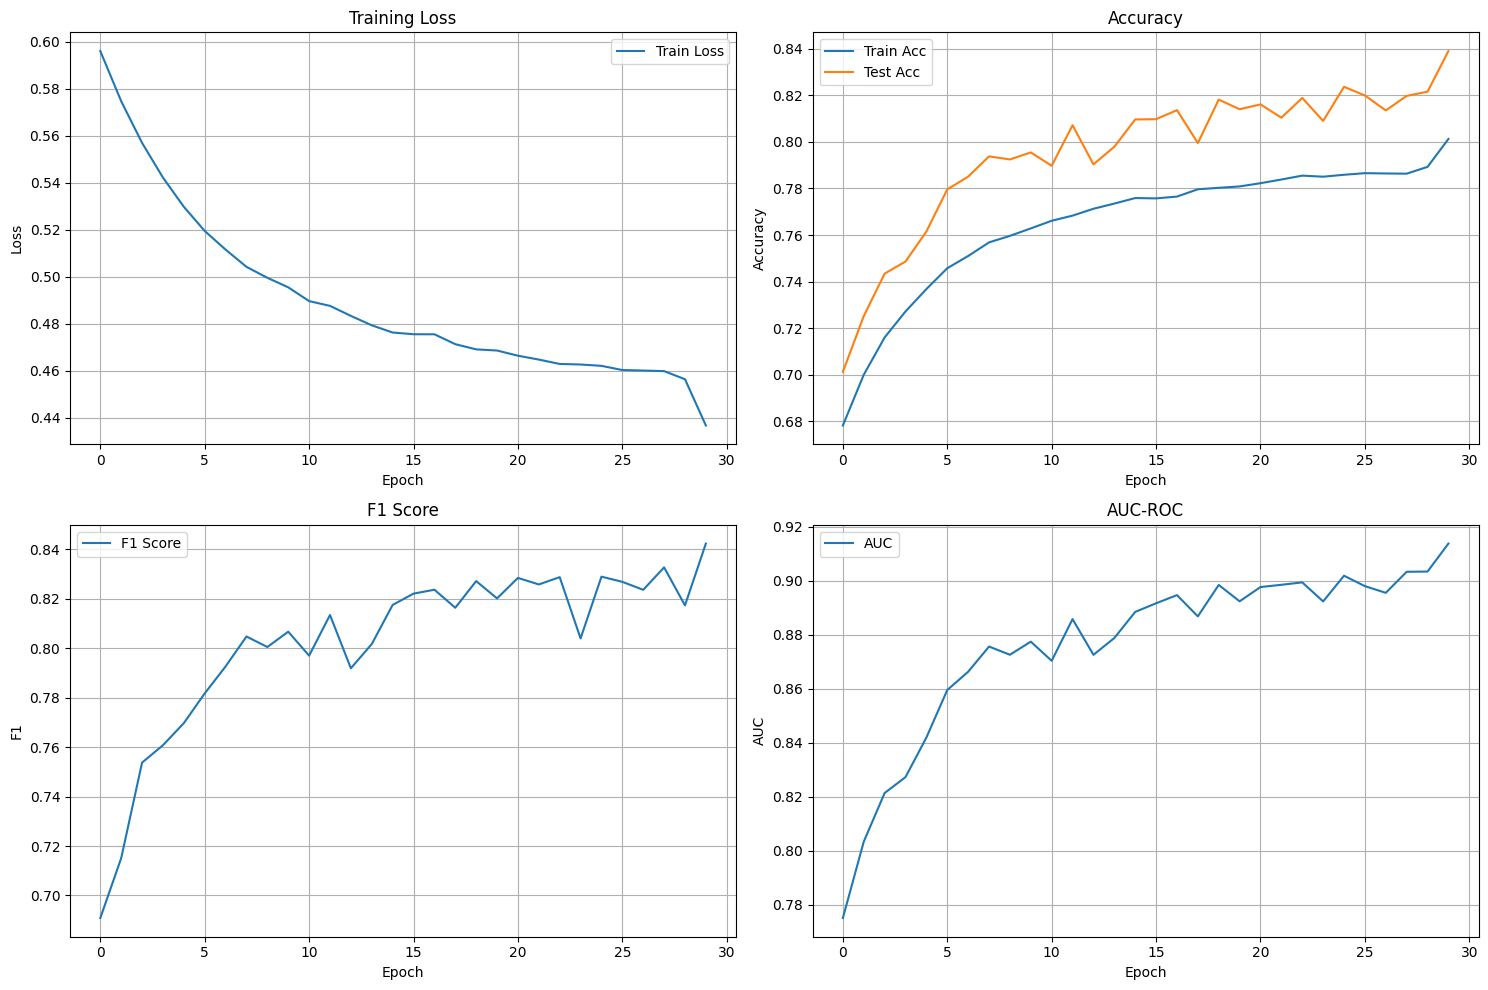

✓ Training plots saved as 'training_history.png'


In [17]:
# ============================================================
# CELL 11: Plot Training History
# ============================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(training_history['train_loss'], label='Train Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(training_history['train_acc'], label='Train Acc')
axes[0, 1].plot(training_history['test_acc'], label='Test Acc')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# F1 Score
axes[1, 0].plot(training_history['test_f1'], label='F1 Score')
axes[1, 0].set_title('F1 Score')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1')
axes[1, 0].legend()
axes[1, 0].grid(True)

# AUC
axes[1, 1].plot(training_history['test_auc'], label='AUC')
axes[1, 1].set_title('AUC-ROC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plots saved as 'training_history.png'")

In [18]:

# ============================================================
# CELL 12: Download Model
# ============================================================

# The model is saved as 'gnn_model.pth'
# Download it from the Kaggle output panel on the right →
print("\n" + "="*60)
print("TO DOWNLOAD YOUR MODEL:")
print("="*60)
print("1. Look at the right panel → Output")
print("2. Find 'gnn_model.pth'")
print("3. Click download icon")
print("4. Use this model in your local app.py!")
print("="*60)


TO DOWNLOAD YOUR MODEL:
1. Look at the right panel → Output
2. Find 'gnn_model.pth'
3. Click download icon
4. Use this model in your local app.py!


In [20]:
#quick EDA setup

In [21]:
import pandas as pd

df = pd.read_csv("/kaggle/input/drug-interaction-dataset/drugbank_train.csv")

print(df.head())
print(df.columns)

   label                                             smile1  \
0    1.0  C[C@@H]1C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@...   
1    1.0  C[C@H]1C[C@H]2[C@@H]3CC[C@](O)(C(=O)CO)[C@@]3(...   
2    1.0  CCOC(=O)N[C@@H]1CC[C@@H]2[C@@H](C1)C[C@H]1C(=O...   
3    0.0  CC(C)C1OC(=O)[C@H](C(C)C)N(C)C(=O)C(C(C)C)OC(=...   
4    1.0                                      NCCc1c[nH]cn1   

                                              smile2  
0   NS(=O)(=O)c1cc2c(cc1Cl)N=C(CSCc1ccccc1)NS2(=O)=O  
1       NS(=O)(=O)c1cc(C(=O)O)cc(N2CCCC2)c1Oc1ccccc1  
2  CCC[C@@]1(CCc2ccccc2)CC(O)=C([C@H](CC)c2cccc(N...  
3              Nc1ccc(S(=O)(=O)Nc2ccnn2-c2ccccc2)cc1  
4         COc1ccc2nc(S(=O)Cc3ncc(C)c(OC)c3C)[nH]c2c1  
Index(['label', 'smile1', 'smile2'], dtype='object')


In [22]:
print(type(df))
print(df.shape)
print(df.columns)


<class 'pandas.core.frame.DataFrame'>
(354436, 3)
Index(['label', 'smile1', 'smile2'], dtype='object')


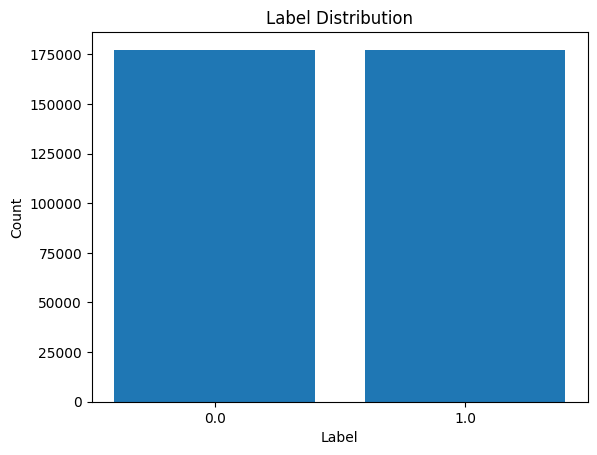

In [23]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts().sort_index()

plt.figure()
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Label Distribution")
plt.show()


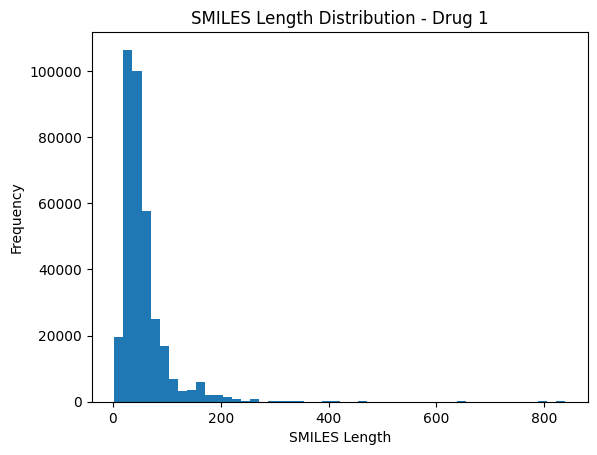

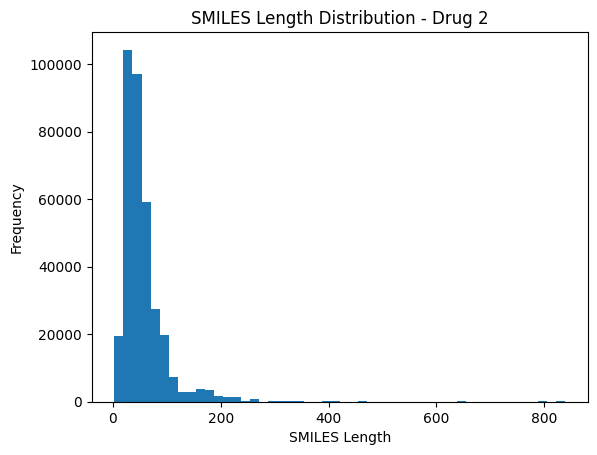

In [25]:
import matplotlib.pyplot as plt

# SMILES lengths
df['len_smile1'] = df['smile1'].str.len()
df['len_smile2'] = df['smile2'].str.len()

# Plot for Drug 1
plt.figure()
plt.hist(df['len_smile1'], bins=50)
plt.xlabel("SMILES Length")
plt.ylabel("Frequency")
plt.title("SMILES Length Distribution - Drug 1")
plt.show()

# Plot for Drug 2
plt.figure()
plt.hist(df['len_smile2'], bins=50)
plt.xlabel("SMILES Length")
plt.ylabel("Frequency")
plt.title("SMILES Length Distribution - Drug 2")
plt.show()


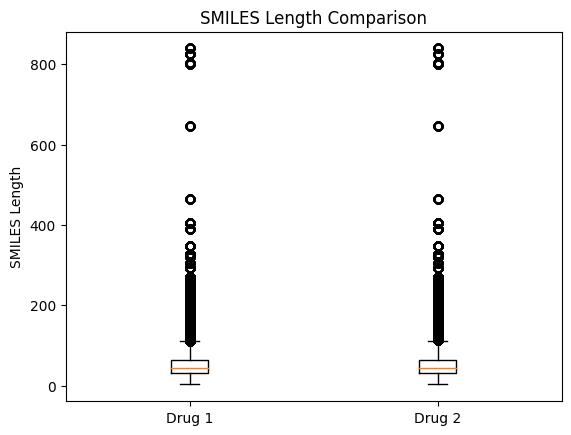

In [26]:
plt.figure()
plt.boxplot([df['len_smile1'], df['len_smile2']], labels=["Drug 1", "Drug 2"])
plt.ylabel("SMILES Length")
plt.title("SMILES Length Comparison")
plt.show()


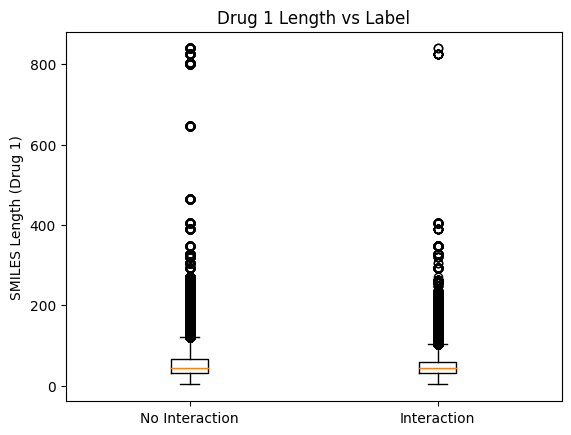

In [27]:
plt.figure()
plt.boxplot(
    [df[df['label']==0]['len_smile1'],
     df[df['label']==1]['len_smile1']],
    labels=['No Interaction', 'Interaction']
)
plt.ylabel("SMILES Length (Drug 1)")
plt.title("Drug 1 Length vs Label")
plt.show()


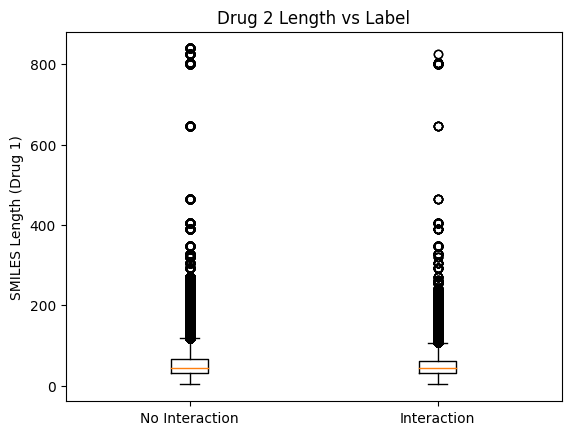

In [28]:
plt.figure()
plt.boxplot(
    [df[df['label']==0]['len_smile2'],
     df[df['label']==1]['len_smile2']],
    labels=['No Interaction', 'Interaction']
)
plt.ylabel("SMILES Length (Drug 1)")
plt.title("Drug 2 Length vs Label")
plt.show()


In [29]:
unique_drugs = pd.unique(df[['smile1', 'smile2']].values.ravel())

print("Total pairs:", len(df))
print("Unique molecules:", len(unique_drugs))


Total pairs: 354436
Unique molecules: 1850


In [32]:
from rdkit import Chem
import torch
from torch_geometric.data import Data

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features: atomic number
    x = torch.tensor(
        [[atom.GetAtomicNum()] for atom in mol.GetAtoms()],
        dtype=torch.float
    )

    # Edges
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append([i, j])
        edge_index.append([j, i])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)


In [33]:
graphs_1 = []
graphs_2 = []

for _, row in df.iterrows():
    g1 = smiles_to_graph(row['smile1'])
    g2 = smiles_to_graph(row['smile2'])

    if g1 is not None and g2 is not None:
        graphs_1.append(g1)
        graphs_2.append(g2)


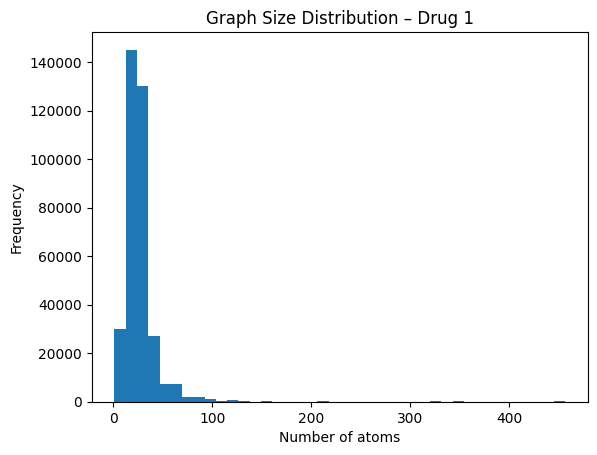

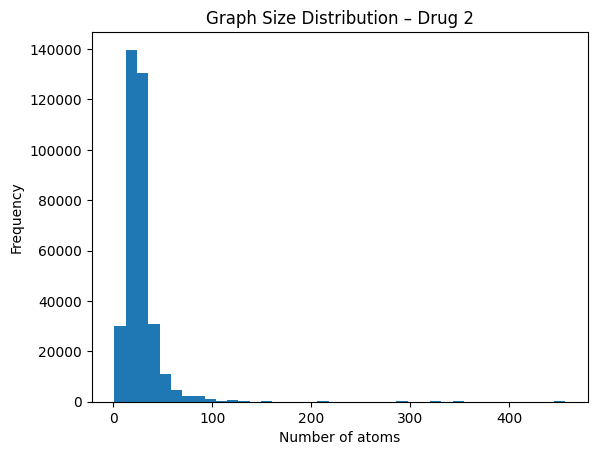

In [34]:
import matplotlib.pyplot as plt

num_nodes_1 = [g.x.size(0) for g in graphs_1]
num_nodes_2 = [g.x.size(0) for g in graphs_2]

plt.figure()
plt.hist(num_nodes_1, bins=40)
plt.xlabel("Number of atoms")
plt.ylabel("Frequency")
plt.title("Graph Size Distribution – Drug 1")
plt.show()

plt.figure()
plt.hist(num_nodes_2, bins=40)
plt.xlabel("Number of atoms")
plt.ylabel("Frequency")
plt.title("Graph Size Distribution – Drug 2")
plt.show()


In [36]:
num_edges_1 = []

for g in graphs_1:
    if g.edge_index is None or g.edge_index.numel() == 0:
        num_edges_1.append(0)
    else:
        num_edges_1.append(g.edge_index.size(1) // 2)  # undirected graph


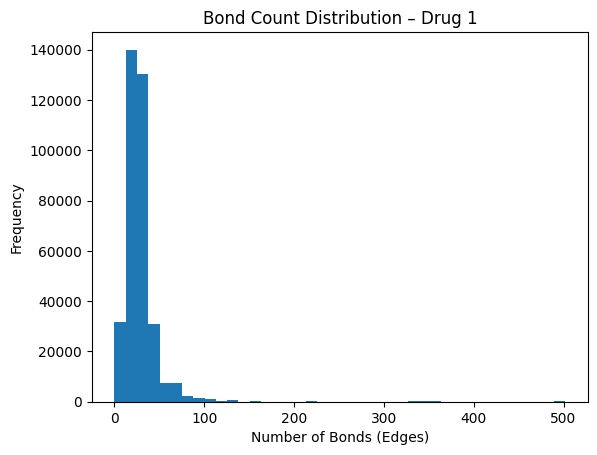

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(num_edges_1, bins=40)
plt.xlabel("Number of Bonds (Edges)")
plt.ylabel("Frequency")
plt.title("Bond Count Distribution – Drug 1")
plt.show()


In [38]:
num_edges_2 = []

for g in graphs_2:
    if g.edge_index is None or g.edge_index.numel() == 0:
        num_edges_2.append(0)
    else:
        num_edges_2.append(g.edge_index.size(1) // 2)  # undirected graph

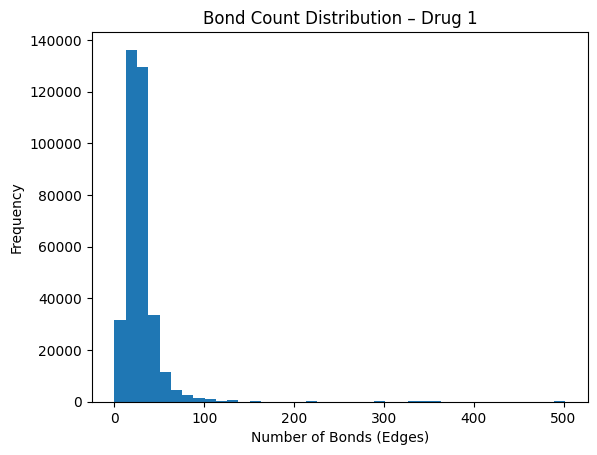

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(num_edges_2, bins=40)
plt.xlabel("Number of Bonds (Edges)")
plt.ylabel("Frequency")
plt.title("Bond Count Distribution – Drug 1")
plt.show()


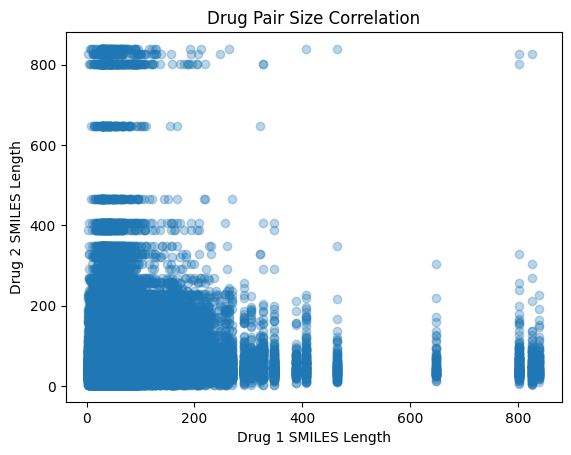

In [40]:
plt.figure()
plt.scatter(df['len_smile1'], df['len_smile2'], alpha=0.3)
plt.xlabel("Drug 1 SMILES Length")
plt.ylabel("Drug 2 SMILES Length")
plt.title("Drug Pair Size Correlation")
plt.show()
